In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [171]:
class Network(nn.Module):

  def __init__(self, input, width, depth, output):
    super().__init__()

    # activation function
    activation = nn.Tanh

    # input layer
    self.fci = nn.Sequential(*[nn.Linear(input, depth), activation()])

    # hidden layers
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(depth, depth), activation()]) for i in range(width-1)])

    # output layer
    self.fco = nn.Linear(depth, output)

  # forward propagation
  def forward(self, x, t):
    x = torch.cat((x, t), dim = 1)
    x = self.fci(x)
    x = self.fch(x)
    x = self.fco(x)
    return x
  
  # numerical solution of spherical diffusion equation
  def NumericalSoln(self, r_rms, t_rms):

    numerical_sol = pd.read_csv("MATLAB Solver\data.csv")
    
    sol = []
    for i in range(len(r_rms)):
      r = np.round(10000 * r_rms[i]).astype(int)[0]
      t = np.round(400 * t_rms[i]).astype(int)[0]  
      
      c = numerical_sol.iloc[r, t]
      sol.append(c)
    return sol
  
  def init_boundaries(self, N):

    # x and t boundary points for training x boundaries, x = 0,1, varying t values
    r0_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True).to(device)
    rs_boundary = torch.tensor(1.).view(-1, 1).requires_grad_(True).to(device)
    t_boundaries = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    # 0 time boundary for training
    t0_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True).to(device)
    r_boundary = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    return r0_boundary, rs_boundary, t_boundaries, t0_boundary, r_boundary
  
  def physics_sample(self, N):
      
      # sample points for training
      r = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)
      t = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)
  
      return r, t
  
  def rms_sample(self, N):
        
        # sample points for training
        r = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)
        t = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)
    
        return r, t
  
  def Diffusion_Coeff(self, c, D_ref):
    # constants
    #D_ref = 2e-16
    c_max = 4.665e4
    C_theory = 277.84
    C_practical = 160

    # equations
    SOC = (c_max - c*c_max)/c_max * C_theory/C_practical
    D = D_ref * (1 + 100*SOC**(3/2))

    return D
  
  def c_r(self, c, r):
    return torch.autograd.grad(c, r, grad_outputs=torch.ones_like(r).to(device), create_graph=True)[0]
  
  def c_rr(self, c, r):
    c_r = self.c_r(c, r)
    return torch.autograd.grad(c_r, r, grad_outputs=torch.ones_like(c_r).to(device), create_graph=True)[0]
  
  def c_t(self, c, t):
    return torch.autograd.grad(c, t, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def constants(self):
    j = -5.35e-5
    Rs = 2e-6
    c_max = 4.665e4
    c0 = torch.tensor(2e4).view(-1, 1).to(device)

    return j, Rs, c_max, c0
  
  def losses(self, r_rms, t_rms, c_numerical, D, N):

    r0_boundary, rs_boundary, t_boundaries, t0_boundary, r_boundary = self.init_boundaries(N)
    r_phys, t_phys = self.physics_sample(N)
    j, Rs, c_max, c0 = self.constants()

    # losses for x and t boundaries
    r0_loss = torch.empty(0).to(device)
    for t in t_boundaries:
      t = t.unsqueeze(1)
      c = self.forward(r0_boundary, t)
      c_r = self.c_r(c, r0_boundary)
      r0_loss = torch.cat((r0_loss, c_r**2), 0)
    
    rs_loss = torch.empty(0).to(device)
    for t in t_boundaries:
      t = t.unsqueeze(1)
      c = self.forward(rs_boundary, t)
      c_r = self.c_r(c, rs_boundary)
      #D = self.Diffusion_Coeff(c.item(), D_ref)
      
      rs_loss = torch.cat((rs_loss, (D*1e-16*c_r + j*Rs/c_max)**2), 0)
    
    t0_loss = torch.empty(0).to(device)
    for r in r_boundary:
      r = r.unsqueeze(1)
      c = self.forward(r, t0_boundary)
      t0_loss = torch.cat((t0_loss, (c_max*c**2 - c0)**2), 0)

    # loss for physics sample
    phys_loss = torch.empty(0).to(device)
    for i in range(len(r_phys)):

      r = r_phys[i].view(-1, 1)
      t = t_phys[i].view(-1, 1)

      c = self.forward(r, t)
      c_r = self.c_r(c, r)
      c_rr = self.c_rr(c, r)
      c_t = self.c_t(c, t)

      #D = self.Diffusion_Coeff(c, D_ref)

      phys_loss = torch.cat((phys_loss, (r**2*c_t - 2*r*D*1e-16/Rs**2*c_r - r**2*D*1e-16/Rs**2*c_rr)**2), 0)
    
    rms_loss = torch.empty(0).to(device)
    for i in range(len(r_rms)):
      c = self.forward(r_rms[i].view(-1, 1), t_rms[i].view(-1, 1))
      rms_loss = torch.cat((rms_loss, (c_max*c - c_numerical[i])**2), 0)
    
    #print(torch.mean(r0_loss).item(), torch.mean(rs_loss).item(), torch.mean(t0_loss).item(), torch.mean(phys_loss).item(), torch.mean(rms_loss).item(), end='\r')
    loss = 1e-3 * (torch.mean(r0_loss) + torch.mean(rs_loss) + torch.mean(t0_loss) + torch.mean(phys_loss)) + torch.mean(rms_loss)  

    return loss
  
  def train(self, epochs, lr, N):

    # get analytical solution for training
    r_rms, t_rms = self.rms_sample(N)
    c_numerical = torch.tensor(self.NumericalSoln(r_rms.cpu().detach().numpy(), t_rms.cpu().detach().numpy())).to(device)

    # initialise parameters and optimiser
    #D_ref = torch.nn.Parameter(torch.tensor(1.).to(device), requires_grad=True)
    D = torch.nn.Parameter(torch.tensor(0.).to(device), requires_grad=True)
    #D_ref = torch.tensor(2e-16)
    Ds = [] 
    losses = []
    optimizer = torch.optim.Adam(list(self.parameters()) + [D], lr = lr)
    #optimizer = torch.optim.Adam(self.parameters(), lr = lr)
    

    for epoch in range(epochs):
      
      optimizer.zero_grad()
      # find loss
      loss = self.losses(r_rms, t_rms, c_numerical, D.item(), N)
      _, _, c_max, _ = self.constants()
      # store parameter and loss values
      Ds.append(D.item())
      losses.append(loss.item())
      # backpropagation
      loss.backward()
      optimizer.step()
      # print loss and parameter values
      print(f'Epoch: {epoch}  Loss: {loss.item()}, D: {D.item()}', end='\r')

      
    self.plot(c_max)
    self.plot_loss_Ds(Ds, losses)
    self.plot_comparison(c_max)

    return Ds, losses

  def plot(self, c_max):
      
      X = torch.linspace(0, 1, 100).to(device)
      T = torch.linspace(0, 1, 100).to(device)
      
      C = np.zeros((len(X), len(T)))
      for i in range(len(X)):
        x = X[i].view(-1, 1)
        for j in range(len(T)):
          t = T[j].view(-1, 1)
          c = self.forward(x, t)
          C[i, j] = c_max * c.item()
      
      X, T = np.meshgrid(X.cpu().detach().numpy(), T.cpu().detach().numpy())
      fig = plt.figure()
      fig.clear()
      ax = fig.add_subplot(111, projection='3d')
      ax.plot_surface(X, T, C, cmap='viridis')
      
      plt.show()



  def plot_loss_Ds(self, Ds, losses):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(Ds)
    plt.xlabel('Epoch')
    plt.ylabel('D')
    plt.title('Parameter D')

    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')

    plt.tight_layout()
    plt.show()

  def plot_comparison(self, c_max):
    
    numerical = pd.read_csv("MATLAB Solver\data.csv")
    X = torch.linspace(0, 1, 100).to(device)
    T = torch.linspace(0, 1, 100).to(device)
    
    C = np.zeros((len(X), len(T)))
    for i in range(len(X)):
      x = X[i].view(-1, 1)
      for j in range(len(T)):
        t = T[j].view(-1, 1)
        c = self.forward(x, t)
        C[i, j] = c_max * c.item()
    

    X = 10000*X.cpu().detach().numpy()
    T = 400*T.cpu().detach().numpy()
    
    fig, axs = plt.subplots(2, 2, figsize=(8, 6))

    axs[0, 0].plot(numerical.iloc[:, 0])
    axs[0, 0].plot(X, C[..., 0])
    axs[0, 0].legend(['Numerical', 'NN'])
    axs[0, 0].set_title('Comparison at t=0')

    axs[0, 1].plot(numerical.iloc[:, -1])
    axs[0, 1].plot(X, C[:, -1])
    axs[0, 1].legend(['Numerical', 'NN'])
    axs[0, 1].set_title('Comparison at t=end')

    axs[1, 0].plot(numerical.iloc[0, :])
    axs[1, 0].plot(T, C[0, :])
    axs[1, 0].legend(['Numerical', 'NN'])
    axs[1, 0].set_title('Comparison at r=0')

    axs[1, 1].plot(numerical.iloc[-1, :])
    axs[1, 1].plot(T, C[-1, :])
    axs[1, 1].legend(['Numerical', 'NN'])
    axs[1, 1].set_title('Comparison at r=end')

    plt.tight_layout()
    plt.show()
    
    plt.legend(['Numerical', 'NN'])

    


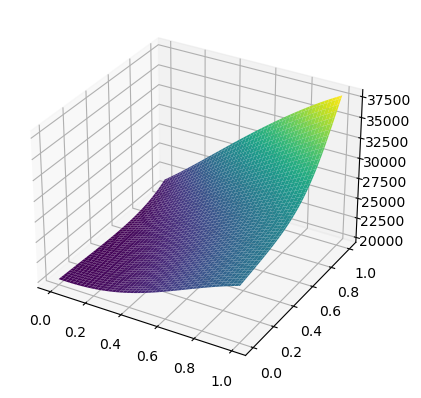

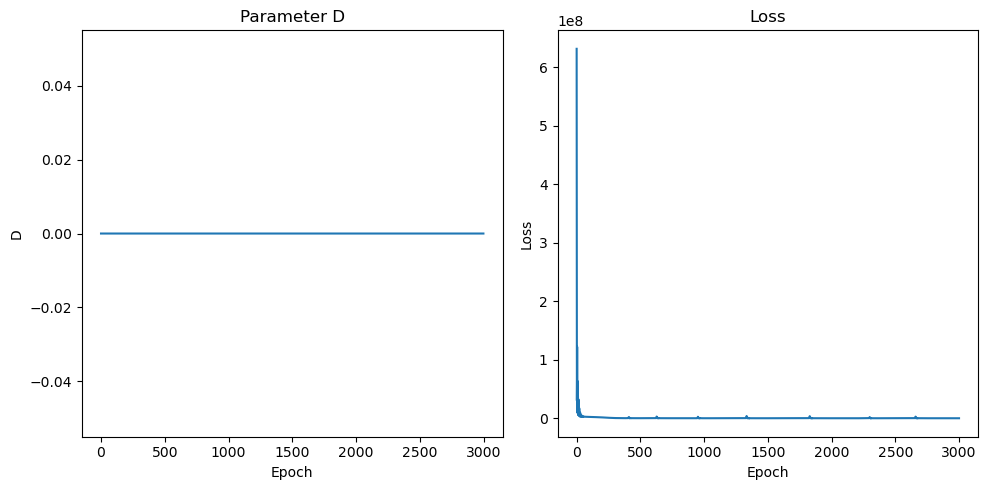

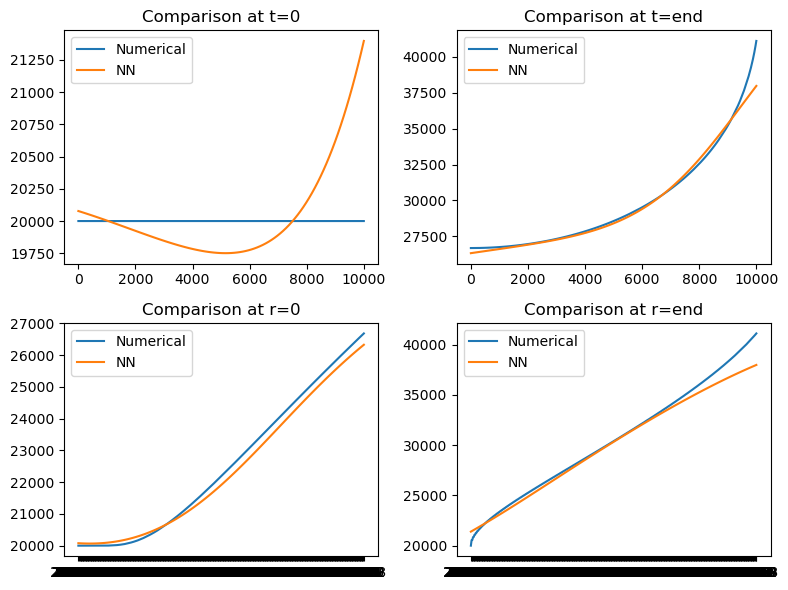

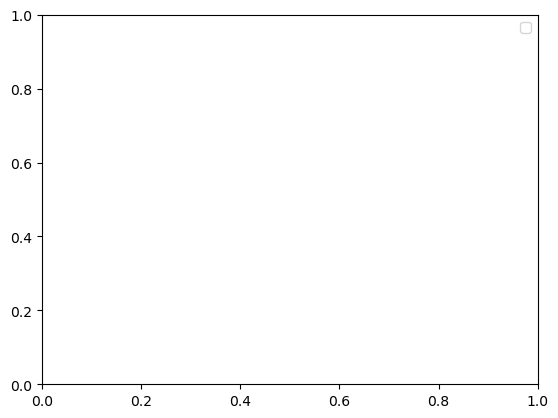

In [172]:
# nn seed
torch.manual_seed(938)
device = 'cpu'

# define nn to train, two inputs for x and t
pinn = Network(2, 5, 128, 1).to(device)

# training things
epochs = 3000
lr = 1e-3
N = 100


Ds, losses = pinn.train(epochs, lr, N)

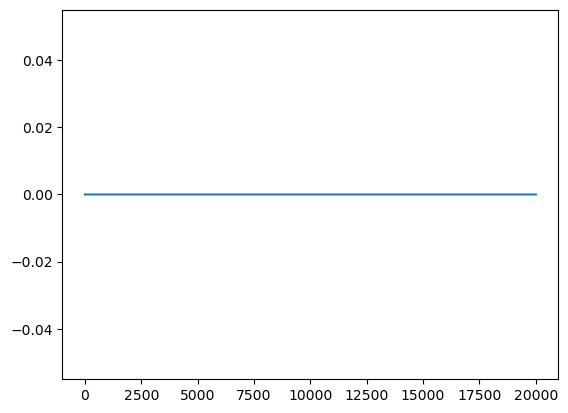

In [135]:
plt.plot(Ds)

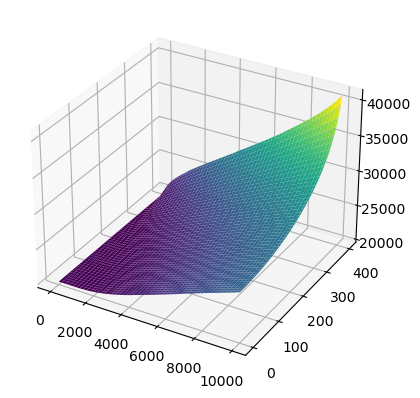

In [132]:
numerical = pd.read_csv("MATLAB Solver\data.csv")

X = np.round(10000 * np.linspace(0, 0.999, 100), 0)
T = np.round(400 * np.linspace(0, 0.999, 100), 0)


    
C = np.zeros((len(X), len(T)))
for i in range(len(X)):
    x = int(X[i])
    for j in range(len(T)):
        t = int(T[j]) 
        C[i, j] = numerical.iloc[x, t]
    
X, T = np.meshgrid(X, T)
fig = plt.figure()
fig.clear()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, C, cmap='viridis')
      
plt.show()




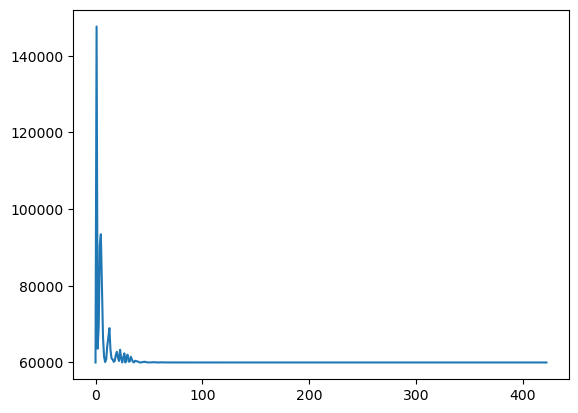

In [154]:
plt.plot(losses)